In [115]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

!pip install scikit-optimize

import skopt

Uncomment the lines below if using with Google Colab to upload the dataset.

In [2]:
# from google.colab import files
# uploaded = files.upload()

We will use the same dataset as the Dimension reduction notebook.

In [16]:
X_in = np.loadtxt('raw_C.txt')
X = X_in[300:, 5000:-1]
print(X.shape)
stim = np.loadtxt('stimmed.txt') 
stim[:,0] = stim[:,0] - 5000 #correct for offset in X time
print(stim.shape)
# for plotting later
color = ['limegreen', 'yellow', 'darkorange', 'orangered', 'purple', 'indigo', 'mediumblue', 'dodgerblue', 'cyan']

(317, 1249)
(179, 8)


(1249,)


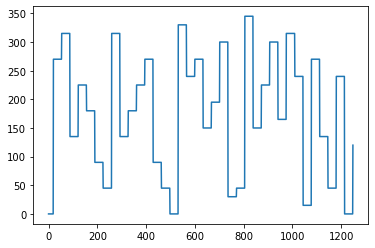

In [45]:
stim_x = np.empty((X.shape[1]))
stim0 = stim[stim[:,0]>=-15,0]

for i in range(X.shape[1]):
    stim_x[i] = stim[np.max(np.where(stim0 <= i)),2]
plt.plot(stim_x)

print(stim_x.shape)

(317, 179)
(179, 8)


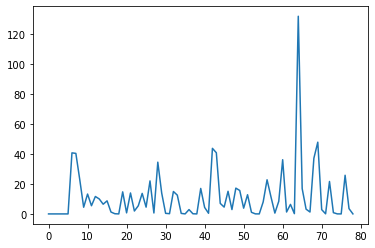

In [95]:
duration = 10
resp = np.zeros((X.shape[0], stim.shape[0]))
for i,s in enumerate(stim):
    resp[:,i] = np.sum(X[:,int(s[0]):int(s[0])+duration], axis=1)
print(resp.shape)
print(stim.shape)
plt.plot(resp[1,100:])

In [116]:
def z_score(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xz = ss.fit_transform(X.T).T
    return Xz

respz = z_score(resp)

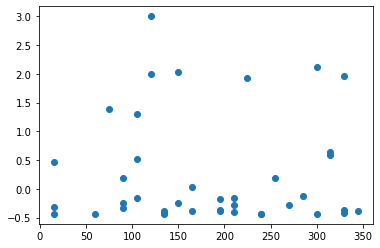

In [117]:
Y_train = respz[9, 100:140]
Y_test = respz[9, 140:]

X_train = stim[100:140,2].reshape(-1,1)
X_test = stim[140:,2].reshape(-1,1)

plt.scatter(X_train, Y_train)

In [48]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

def objective(args):
    alpha=args[0]
    fit_intercept=args[1]
    solver=args[2]

    reg = Ridge(alpha=alpha, fit_intercept=fit_intercept, solver=solver, random_state=123)

    reg.fit(X_train, Y_train)
    Y_pred = reg.predict(X_test)

    return mean_squared_error(Y_test, Y_pred)

In [167]:
from skopt import space

search_space = space.Space([
                 space.Real(1e-3, 2, prior="uniform", transform="identity", name="alpha"),
                 space.Categorical([True, False], name="fit_intercept"),
                 space.Categorical(["cholesky", "saga", "lsqr", "sag", "svd", "sparse_cg"], name="solver"),
               ])

In [168]:
from skopt import gp_minimize

res_reg = gp_minimize(objective, search_space, n_calls=30, random_state=13, n_jobs=-1)

/Users/hawkwings/miniforge3/envs/improv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/hawkwings/miniforge3/envs/improv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/hawkwings/miniforge3/envs/improv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/hawkwings/miniforge3/envs/improv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/hawkwings/miniforge3/envs/improv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarnin

In [169]:
best_params = dict(list(zip(["alpha", "fit_intercept", "solver"], res_reg.x)))

print("Best Parameters : {}".format(best_params))
print("Best MSE : {}".format(res_reg.fun))

Best Parameters : {'alpha': 0.10662028299587016, 'fit_intercept': True, 'solver': 'saga'}
Best MSE : 2.781502225227969


In [170]:
reg = Ridge(**best_params, random_state=123)

reg.fit(X_train, Y_train)

print("Train MSE : {:.2f}".format(mean_squared_error(Y_train, reg.predict(X_train))))
print("Test  MSE : {:.2f}".format(mean_squared_error(Y_test, reg.predict(X_test))))

Train MSE : 0.87
Test  MSE : 2.78


array([[<AxesSubplot:xlabel='alpha', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='fit_intercept'>,
        <AxesSubplot:xlabel='fit_intercept', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='alpha', ylabel='solver'>,
        <AxesSubplot:xlabel='fit_intercept'>,
        <AxesSubplot:xlabel='solver', ylabel='Partial dependence'>]],
      dtype=object)

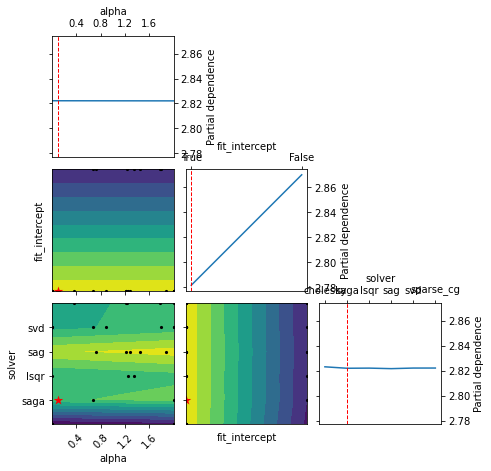

In [171]:
from skopt import plots
plots.plot_objective(res_reg)

<AxesSubplot:xlabel='alpha', ylabel='solver'>

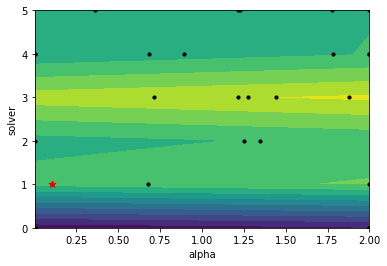

In [172]:
plots.plot_objective_2D(res_reg, dimension_identifier1="alpha", dimension_identifier2="solver")

array([[<AxesSubplot:xlabel='alpha', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='fit_intercept'>,
        <AxesSubplot:xlabel='fit_intercept', ylabel='Number of samples'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='alpha', ylabel='solver'>,
        <AxesSubplot:xlabel='fit_intercept'>,
        <AxesSubplot:xlabel='solver', ylabel='Number of samples'>]],
      dtype=object)

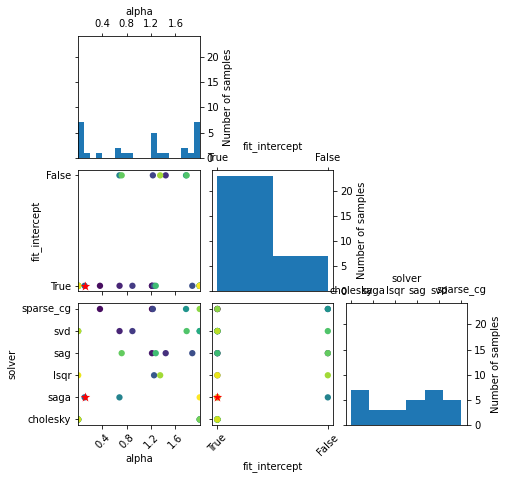

In [173]:
plots.plot_evaluations(res_reg)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

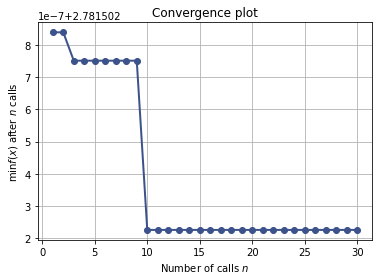

In [174]:
plots.plot_convergence(res_reg)

In [ ]:
# Some example code from: https://coderzcolumn.com/tutorials/machine-learning/scikit-optimize-guide-to-hyperparameters-optimization